# Imports

In [361]:
pip install pandas

In [362]:
pip install scikit-learn

In [363]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [368]:
from google.colab import files
data = files.upload()

Saving supermarket_sales.csv to supermarket_sales (1).csv


In [365]:
import pickle

In [366]:
from sklearn.metrics import confusion_matrix

# Random Forest + KNN - Churn Dataset



In [367]:
churn = pd.read_excel('Churn.xlsx')

## EDA

In [370]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SubscriptionID       15561 non-null  int64 
 1   Household Income     15561 non-null  object
 2   Home Ownership       15561 non-null  object
 3   Children             15561 non-null  object
 4   Year Of Residence    15561 non-null  int64 
 5   Age range            15561 non-null  object
 6   State                15561 non-null  object
 7   City                 15561 non-null  object
 8   County               15561 non-null  object
 9   Zip Code             15561 non-null  int64 
 10  Weekly Fee           15561 non-null  object
 11  Delivery Period      15561 non-null  object
 12  Recruitment Channel  15561 non-null  object
 13  Subscriber           15561 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.7+ MB


No missing values in the dataset, so no cleaning to do.

In [371]:
churn.head()

,SubscriptionID,Household Income,Home Ownership,Children,Year Of Residence,Age range,State,City,County,Zip Code,Weekly Fee,Delivery Period,Recruitment Channel,Subscriber
0,180590686,"$ 30,000 - $39,999",RENTER,N,1,25-29,CA,LONG BEACH,LOS ANGELES,90802,$7.00 - $7.99,7Day,Website,NO
1,181401653,"$500,000 Plus",OWNER,Y,14,50-54,CA,NEWPORT COAST,ORANGE,92657,$1.00 - $4.99,SunOnly,Direct Marketing,YES
2,180374685,"$100,000 - $124,999",OWNER,Y,7,45-49,CA,IRVINE,ORANGE,92604,$1.00 - $4.99,SunOnly,Direct Marketing,YES
3,180703483,"$200,000 - $249,999",OWNER,N,23,55-59,CA,LAGUNA NIGUEL,ORANGE,92677,$1.00 - $4.99,SunOnly,Website,NO
4,180358906,"$ 50,000 - $59,999",OWNER,N,23,60-64,CA,RANCHO SANTA MARGARITA,ORANGE,92688,$8.00 - $8.99,Thu-Sun,Website,YES


Let's first see the repartition of Subscribed and Unsubscribed people in the dataset.

<Axes: xlabel='Subscriber', ylabel='count'>

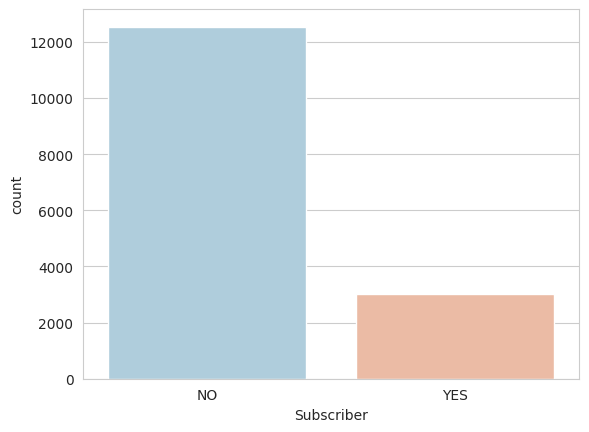

In [372]:
sns.set_style('whitegrid')
sns.countplot(x='Subscriber', data=churn, palette='RdBu_r')

As we can see, the dataset is not balanced between subscribed and unsubcribed people.

Now let's focus on the repartition of Household income.

In [373]:
churn.groupby(['Household Income']).count()["SubscriptionID"]

Household Income
$  20,000 - $29,999    1133
$  30,000 - $39,999     898
$  40,000 - $49,999    1070
$  50,000 - $59,999     859
$  60,000 - $69,999     828
$  70,000 - $79,999     864
$  80,000 - $89,999     845
$  90,000 - $99,999     832
$100,000 - $124,999    1736
$125,000 - $149,999    1340
$150,000 - $174,999     853
$175,000 - $199,999     607
$200,000 - $249,999     501
$250,000 - $299,999      18
$300,000 - $399,999     814
$400,000 - $499,999     255
$500,000 Plus           224
Under $20,000          1884
Name: SubscriptionID, dtype: int64

The data is not really usable in this state. So, for each range of salary, we are going to attribute it the smallest income to be able to convert it into an integer.

In [374]:
churn["Household Income"] = churn["Household Income"].apply(lambda x: x.replace(" ", ""))

In [375]:
churn["Household Income"] = churn["Household Income"].apply(lambda x: x.replace("$", ""))

In [376]:
churn['Household Income'] = churn['Household Income'].map(lambda x: x.rstrip('1234567890,Plus'))

In [377]:
churn["Household Income"] = churn["Household Income"].apply(lambda x: x.replace("-", ""))

In [378]:
churn["Household Income"] = churn["Household Income"].apply(lambda x: x.replace("Under", "0"))

In [379]:
churn["Household Income"] = churn["Household Income"].apply(lambda x: x.replace(",", ""))

In [380]:
churn["Household Income"] = churn["Household Income"].replace('', "500000")

In [381]:
churn["Household Income"] = pd.to_numeric(churn["Household Income"])

In [382]:
churn.groupby(['Household Income']).count()["SubscriptionID"]

Household Income
0         1884
20000     1133
30000      898
40000     1070
50000      859
60000      828
70000      864
80000      845
90000      832
100000    1736
125000    1340
150000     853
175000     607
200000     501
250000      18
300000     814
400000     255
500000     224
Name: SubscriptionID, dtype: int64

And that gives us the following repartition of income.

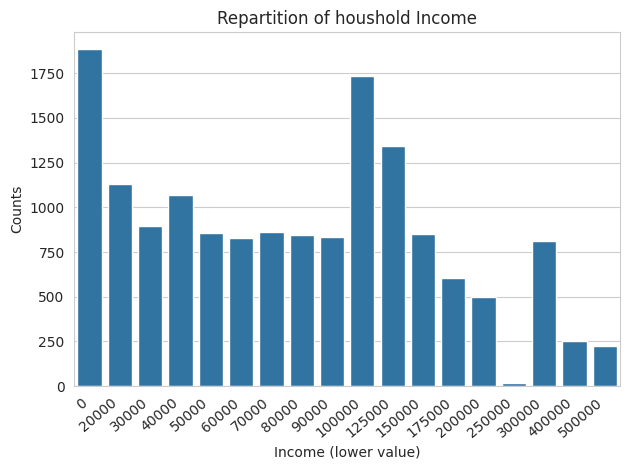

In [383]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Household Income', data=churn)

plt.xlabel("Income (lower value)")
plt.ylabel("Counts")
plt.title("Repartition of houshold Income")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We will now look at the different options of weekly fee. Again, the data is only disponible as a range, so we are taking the lower limit for each group.

In [384]:
churn["Weekly Fee"]

0        $7.00 - $7.99
1        $1.00 - $4.99
2        $1.00 - $4.99
3        $1.00 - $4.99
4        $8.00 - $8.99
             ...      
15556    $1.00 - $4.99
15557    $1.00 - $4.99
15558    $1.00 - $4.99
15559    $1.00 - $4.99
15560    $1.00 - $4.99
Name: Weekly Fee, Length: 15561, dtype: object

In [385]:
churn["Weekly Fee"] = churn["Weekly Fee"].apply(lambda x: x.replace(" ", ""))
churn["Weekly Fee"] = churn["Weekly Fee"].apply(lambda x: x.replace("$", ""))
churn["Weekly Fee Lower"] = churn['Weekly Fee'].map(lambda x: x.rstrip('1234567890.'))
churn["Weekly Fee Lower"] = churn['Weekly Fee Lower'].apply(lambda x: x.replace("-", ""))
churn["Weekly Fee Lower"] = pd.to_numeric(churn["Weekly Fee Lower"])
churn["Weekly Fee Upper"] = churn['Weekly Fee'].map(lambda x: x.lstrip('1234567890.'))
churn["Weekly Fee Upper"] = churn['Weekly Fee Upper'].apply(lambda x: x.replace("-", ""))
churn["Weekly Fee Upper"] = pd.to_numeric(churn["Weekly Fee Upper"])

In [386]:
sorted(churn["Weekly Fee Lower"].unique())

[1.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [387]:
sorted(churn["Weekly Fee Upper"].unique())

[4.99, 5.99, 6.99, 7.99, 8.99, 9.99, 10.99]

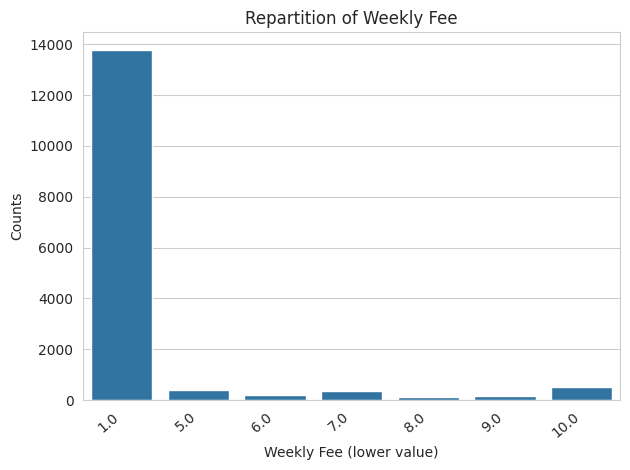

In [388]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Weekly Fee Lower', data=churn)

plt.xlabel("Weekly Fee (lower value)")
plt.ylabel("Counts")
plt.title("Repartition of Weekly Fee")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We can see that most weekly fees are between 1 and 5 euros.

A more interesting information to keep is the part of people's budget going into those weekly fees.

In [389]:
churn["Prop. of weekly fee"] = churn["Weekly Fee Lower"]/churn["Household Income"]

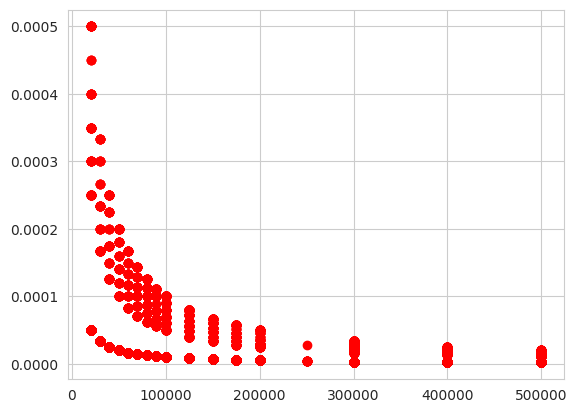

In [390]:
plt.plot(churn["Household Income"], churn["Prop. of weekly fee"], 'ro')

Of course, among households with smaller income, weekly fees represent a bigger part of the budget then for those with higher income.

Moreover, people with smaller budget don't really adapt their weekly fees to their budget.

Now let's look at a few graphs around home ownership.

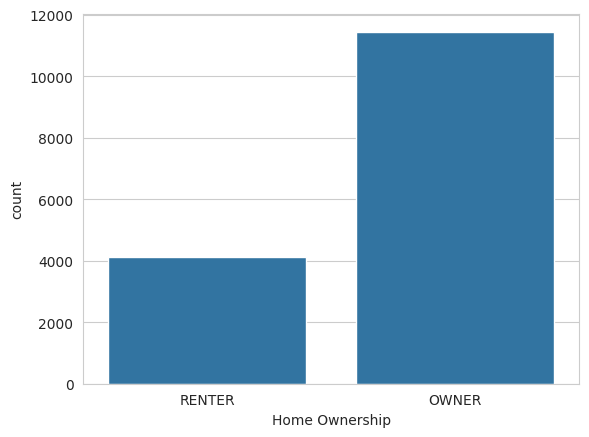

In [391]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Home Ownership', data=churn)

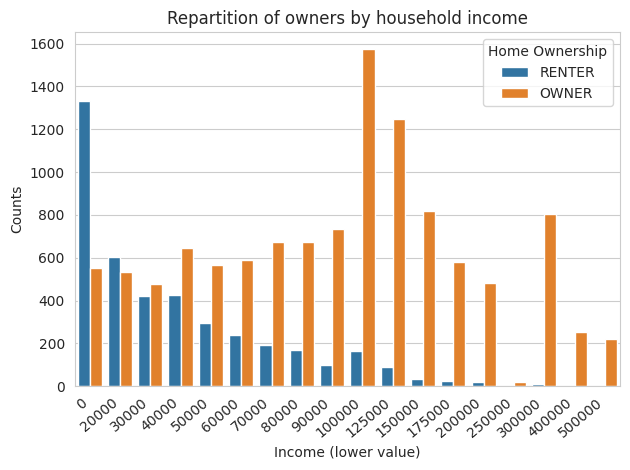

In [392]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Household Income', hue = 'Home Ownership', data=churn)

plt.xlabel("Income (lower value)")
plt.ylabel("Counts")
plt.title("Repartition of owners by household income")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

As we could imagine, the richer the people, the more they tend to own their house rather than pay a rent.

Now, we can look at a few graphs recording age.

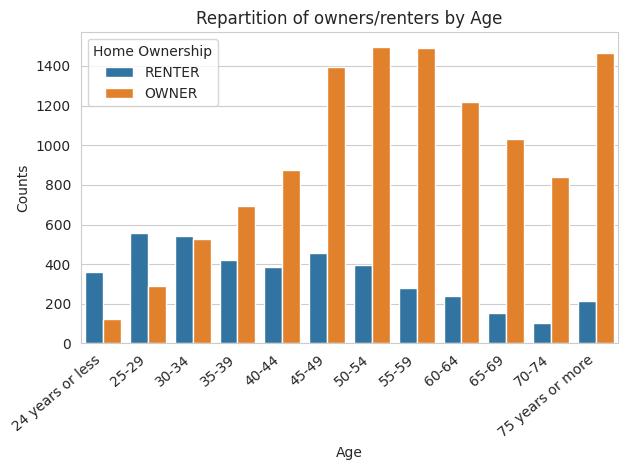

In [393]:
churn_age = churn.sort_values('Age range')
sns.set_style('whitegrid')
ax = sns.countplot(x='Age range', hue = 'Home Ownership', data=churn_age)

plt.xlabel("Age")
plt.ylabel("Counts")
plt.title("Repartition of owners/renters by Age")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In this graph, we can see that older people tend to own houses when younger people rent it.

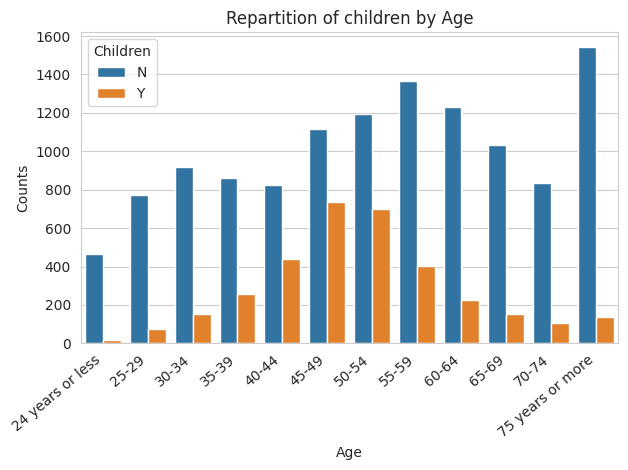

In [394]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Age range', hue = 'Children', data=churn_age)

plt.xlabel("Age")
plt.ylabel("Counts")
plt.title("Repartition of children by Age")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

As expected, the proportion of people with children augments with the age. However, we can also see with this graph that children seem to leave the house when their parents are around 50 years old, as the proportion of houses with children diminishes after that value.

In [395]:
churn_age_bis = churn.groupby(['Age range']).mean('Year Of Residence')

In [396]:
churn_age_bis['Age'] = churn_age_bis.index

The next plot represents the mean years of residence of people in their current house depending on theit age.

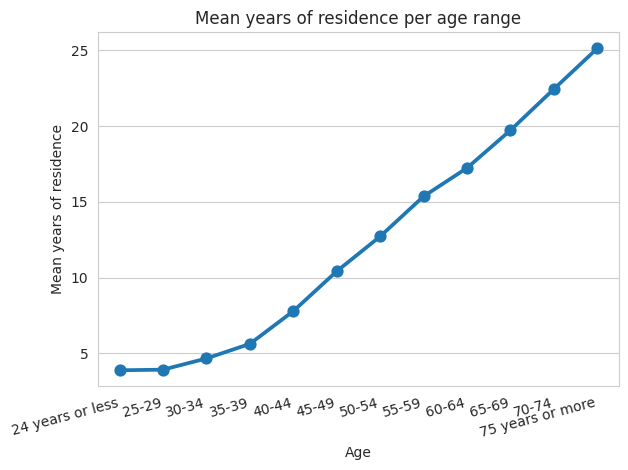

In [397]:
ax = sns.pointplot(churn_age_bis, x = 'Age', y = "Year Of Residence")

plt.xlabel("Age")
plt.ylabel("Mean years of residence")
plt.title("Mean years of residence per age range")

ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
plt.tight_layout()
plt.show()

We can see with this plot that people tend to settle down after 35 to 40 years of age. Indeed, the years of residence grow linearly with the age only after 35 to 40 years of age.

In [398]:
churn['State'].unique()

array(['CA'], dtype=object)

There is only one state so we can drop the column, it won't give us more information.

In [399]:
churn.drop('State', inplace = True, axis = 1)

In [400]:
churn.groupby('County').mean("Household Income")["Household Income"].sort_values(ascending = False)

County
SAN BERNARDINO    148760.683761
RIVERSIDE         130325.379610
ORANGE             97508.448324
LOS ANGELES        81732.991014
Name: Household Income, dtype: float64

In [401]:
churn.groupby('County').mean("Weekly Fee Upper")["Weekly Fee Upper"].sort_values(ascending = False)

County
ORANGE            5.419879
LOS ANGELES       5.296804
SAN BERNARDINO    5.101111
RIVERSIDE         5.074599
Name: Weekly Fee Upper, dtype: float64

The county with the highest incomes are not the most likely to have people paying for a higher subscription.

Now let's focus on delivery periods.

In [402]:
churn['Delivery Period'].unique()

array(['7Day', 'SunOnly', 'Thu-Sun', 'SatSun', 'Mon-Fri', 'Fri-Sun',
       'Sun-Fri'], dtype=object)

In [403]:
churn_delivery = churn.groupby(['Delivery Period']).mean('Household Income').sort_values(by = 'Household Income', ascending=False)['Household Income']

<Axes: xlabel='Delivery Period', ylabel='Household Income'>

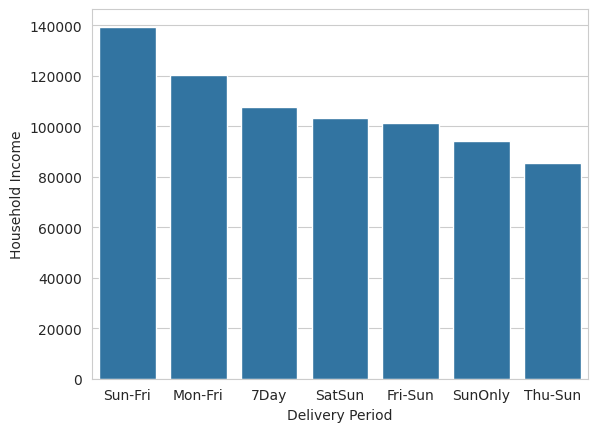

In [404]:
sns.barplot(churn_delivery)

We can see that the higher the household income, the more likely they are to be delivered during the week. Wheareas lower incomes are more likely to be delivered during the week-end.

Now let's focus on the "Recruitment Channel" column.

In [405]:
churn['Recruitment Channel'].unique()

array(['Website', 'Direct Marketing'], dtype=object)

There are only 2 recruitment channels and we are going to look at their repatition among age categories.

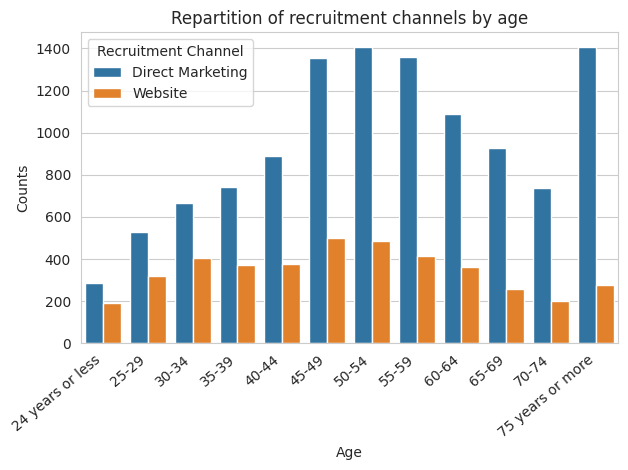

In [406]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Age range', hue = 'Recruitment Channel', data=churn_age)

plt.xlabel("Age")
plt.ylabel("Counts")
plt.title("Repartition of recruitment channels by age")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We see that the proportion of Direct Marketing augments with the age. And it is quite logical, older people are known to spend less time on the Internet.

## Cleaning and preprocessing

In [407]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SubscriptionID       15561 non-null  int64  
 1   Household Income     15561 non-null  int64  
 2   Home Ownership       15561 non-null  object 
 3   Children             15561 non-null  object 
 4   Year Of Residence    15561 non-null  int64  
 5   Age range            15561 non-null  object 
 6   City                 15561 non-null  object 
 7   County               15561 non-null  object 
 8   Zip Code             15561 non-null  int64  
 9   Weekly Fee           15561 non-null  object 
 10  Delivery Period      15561 non-null  object 
 11  Recruitment Channel  15561 non-null  object 
 12  Subscriber           15561 non-null  object 
 13  Weekly Fee Lower     15561 non-null  float64
 14  Weekly Fee Upper     15561 non-null  float64
 15  Prop. of weekly fee  15561 non-null 

In [408]:
churn.head()

,SubscriptionID,Household Income,Home Ownership,Children,Year Of Residence,Age range,City,County,Zip Code,Weekly Fee,Delivery Period,Recruitment Channel,Subscriber,Weekly Fee Lower,Weekly Fee Upper,Prop. of weekly fee
0,180590686,30000,RENTER,N,1,25-29,LONG BEACH,LOS ANGELES,90802,7.00-7.99,7Day,Website,NO,7.0,7.99,0.000233
1,181401653,500000,OWNER,Y,14,50-54,NEWPORT COAST,ORANGE,92657,1.00-4.99,SunOnly,Direct Marketing,YES,1.0,4.99,0.000002
2,180374685,100000,OWNER,Y,7,45-49,IRVINE,ORANGE,92604,1.00-4.99,SunOnly,Direct Marketing,YES,1.0,4.99,0.000010
3,180703483,200000,OWNER,N,23,55-59,LAGUNA NIGUEL,ORANGE,92677,1.00-4.99,SunOnly,Website,NO,1.0,4.99,0.000005
4,180358906,50000,OWNER,N,23,60-64,RANCHO SANTA MARGARITA,ORANGE,92688,8.00-8.99,Thu-Sun,Website,YES,8.0,8.99,0.000160


In [409]:
inputs = churn.drop('Subscriber', axis = 'columns')

In [410]:
target = churn['Subscriber']

We are going to get rid of useless columns such as 'SubscriptionID', who are just random numbers.


In [411]:
inputs.drop('SubscriptionID', inplace = True, axis = 1)

And use dummy variables for other columns.

In [412]:
dummies_home = pd.get_dummies(churn['Home Ownership'], drop_first=True)
dummies_home.head(3)

,RENTER
0,True
1,False
2,False


In [413]:
inputs.drop('Home Ownership', inplace = True, axis = 1)

In [414]:
inputs['Children'].replace(to_replace=["N", "Y"], value=[False, True], inplace = True)
inputs['Children'].head()

0    False
1     True
2     True
3    False
4    False
Name: Children, dtype: bool

The age ranges are not usable like that so we can replace them by the mean of the ranges in question.

In [415]:
inputs['Age range'].unique()

array(['25-29', '50-54', '45-49', '55-59', '60-64', '75 years or more',
       '65-69', '70-74', '40-44', '24 years or less', '35-39', '30-34'],
      dtype=object)

In [416]:
inputs['Age range'].replace(to_replace=["24 years or less", "75 years or more"], value=["21-24", "75-85"], inplace = True)

In [417]:
inputs['Age'] = inputs['Age range'].apply( lambda x: (int(x.split("-")[0])+int(x.split("-")[1]))/2 )

In [418]:
inputs.drop('Age range', inplace = True, axis = 1)

We can then leave out the cities and Zip codes as they are nearly unique for each row, and leave dummy variables for the counties.

In [419]:
inputs.drop('City', inplace = True, axis = 1)

In [420]:
dummies_county = pd.get_dummies(inputs['County'], drop_first=True)
dummies_county.head(3)

,ORANGE,RIVERSIDE,SAN BERNARDINO
0,False,False,False
1,True,False,False
2,True,False,False


In [421]:
inputs.drop('County', inplace = True, axis = 1)

In [422]:
inputs.drop('Zip Code', inplace = True, axis = 1)

We already took care of the weekly fee column so we can drop it.

In [423]:
inputs.drop('Weekly Fee', inplace = True, axis = 1)

We replace delivery periods and Recruitment channels by dummy varibles.

In [424]:
dummies_delivery = pd.get_dummies(inputs['Delivery Period'], drop_first=True)
dummies_delivery.head(3)

,Fri-Sun,Mon-Fri,SatSun,Sun-Fri,SunOnly,Thu-Sun
0,False,False,False,False,False,False
1,False,False,False,False,True,False
2,False,False,False,False,True,False


In [425]:
inputs.drop('Delivery Period', inplace = True, axis = 1)

In [426]:
dummies_recruitment = pd.get_dummies(inputs['Recruitment Channel'], drop_first=True)
dummies_recruitment.head(3)

,Website
0,True
1,False
2,False


In [427]:
inputs.drop('Recruitment Channel', inplace = True, axis = 1)

Same for the target column 'Subscribed'.

In [428]:
target.replace(to_replace=["NO", "YES"], value=[False, True], inplace = True)
target.head()

0    False
1     True
2     True
3    False
4     True
Name: Subscriber, dtype: bool

And we leave out the proportion of the weekly fee in each budget used in a previous graph.

In [429]:
inputs.drop('Prop. of weekly fee', inplace = True, axis = 1)

In [430]:
inputs.head()

,Household Income,Children,Year Of Residence,Weekly Fee Lower,Weekly Fee Upper,Age
0,30000,False,1,7.0,7.99,27.0
1,500000,True,14,1.0,4.99,52.0
2,100000,True,7,1.0,4.99,47.0
3,200000,False,23,1.0,4.99,57.0
4,50000,False,23,8.0,8.99,62.0


Eventually, we put every dummy variables back together.

In [431]:
inputs = pd.concat([inputs, dummies_county, dummies_delivery, dummies_recruitment], axis = 'columns')

In [432]:
inputs.head()

,Household Income,Children,Year Of Residence,Weekly Fee Lower,Weekly Fee Upper,Age,ORANGE,RIVERSIDE,SAN BERNARDINO,Fri-Sun,Mon-Fri,SatSun,Sun-Fri,SunOnly,Thu-Sun,Website
0,30000,False,1,7.0,7.99,27.0,False,False,False,False,False,False,False,False,False,True
1,500000,True,14,1.0,4.99,52.0,True,False,False,False,False,False,False,True,False,False
2,100000,True,7,1.0,4.99,47.0,True,False,False,False,False,False,False,True,False,False
3,200000,False,23,1.0,4.99,57.0,True,False,False,False,False,False,False,True,False,True
4,50000,False,23,8.0,8.99,62.0,True,False,False,False,False,False,False,False,True,True


In [433]:
target.head()

0    False
1     True
2     True
3    False
4     True
Name: Subscriber, dtype: bool

## Export cleaned datasets

In [434]:
inputs["Subscriber"] = target

In [435]:
inputs.head()

,Household Income,Children,Year Of Residence,Weekly Fee Lower,Weekly Fee Upper,Age,ORANGE,RIVERSIDE,SAN BERNARDINO,Fri-Sun,Mon-Fri,SatSun,Sun-Fri,SunOnly,Thu-Sun,Website,Subscriber
0,30000,False,1,7.0,7.99,27.0,False,False,False,False,False,False,False,False,False,True,False
1,500000,True,14,1.0,4.99,52.0,True,False,False,False,False,False,False,True,False,False,True
2,100000,True,7,1.0,4.99,47.0,True,False,False,False,False,False,False,True,False,False,True
3,200000,False,23,1.0,4.99,57.0,True,False,False,False,False,False,False,True,False,True,False
4,50000,False,23,8.0,8.99,62.0,True,False,False,False,False,False,False,False,True,True,True


In [436]:
inputs.to_csv('CleanedChurn.csv')
files.download('CleanedChurn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Train-Test Split

In [437]:
from sklearn.model_selection import train_test_split

In [438]:
# 80 - 20 Split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.2, random_state = 10)

## Random Forest

In [439]:
from sklearn.ensemble import RandomForestClassifier

In [440]:
from sklearn.model_selection import cross_val_score

We will create a first model with 100 trees in the forest. To see the result, we will use the cross validation method with the training dataset.

In [441]:
random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, X_train, y_train, cv = 5)
scores

array([1., 1., 1., 1., 1.])

In [442]:
np.mean(scores)

1.0

Next, let's find the best number of trees to put on the model thanks to a loop. During each repetition, 10 cross validation scores will be mesured and the mean will be taken as the final score.

In [443]:
n_tree = []
scores = []
max, maxi = 0, 0
for trees in range(1, 150):
  print(trees)
  n_tree.append(trees)
  score = 0
  for i in range(10):
    rf = RandomForestClassifier(n_estimators = trees)
    score += np.mean(cross_val_score(rf, X_train, y_train, cv = 5))
  scores.append(score/10)
  if score/10 > maxi:
    maxi = score/10
    max = trees
print(maxi, max)

1
2
3
4
5
6
7


KeyboardInterrupt: 

The best score obtained was 0.799 with 132 trees.

Next is the graph of the scores obtained for the number of trees going from 1 to 150.

In [ ]:
plt.plot(n_tree, scores)
plt.xlabel('Number of trees')
plt.ylabel('Precision of the algorithm')
plt.title('Decision tree algorithm result')

With this modele, we can also change other parameters, such as the minimum number of samples required to split an internal node (*min_samples_split*), or the function that measure the quality of a split (*criterion*).
Next is an evaluation of the model when changing those parameters.

In [ ]:
best_score = 0
best = ["gini", 2]
for crit in ["gini", "entropy", "log_loss"]:
  for min_sample in range(2, 6):
    random_forest = RandomForestClassifier(n_estimators = 132, min_samples_split = min_sample, criterion = crit)
    score = np.mean(cross_val_score(random_forest, X_train, y_train, cv = 5))
    if score > best_score:
      best_score = score
      best = [crit, min_sample]
print(best, best_score)

The best model with 132 trees was obtained with [min_sample_slit, criterion] = [5, 'entropy"].



In [444]:
random_forest = RandomForestClassifier(n_estimators = 132, min_samples_split = 5, criterion = "entropy")
random_forest.fit(X_train, y_train)
y_predict = random_forest.predict(X_test)

In [445]:
from sklearn.metrics import confusion_matrix

In [446]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[2518,    0],
       [   0,  595]])

The next heatmap is a visual representation of the confusion matrix obtained with the best model.

Text(95.72222222222221, 0.5, 'Truth')

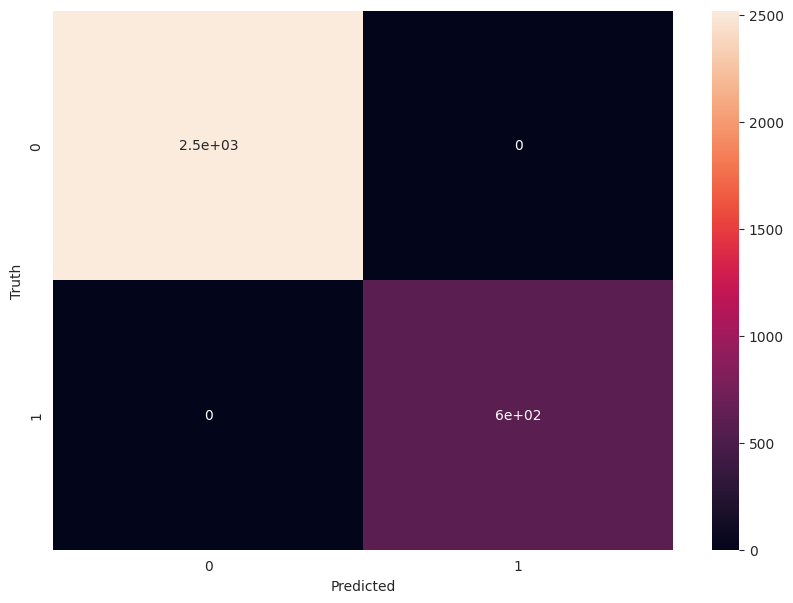

In [447]:
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Next is the score of the best model on the test set.

In [ ]:
tn, fp, fn, tp = cm.ravel()

In [ ]:
Acc = (tp + tn)/(tp + tn + fn + fp)
Pre = tp/(tp + fp)
Rec = tp/(tp + fn)

In [ ]:
Acc

In [ ]:
Pre

In [ ]:
Rec

The accuracy = 0.808

The presicion = 0.496

The recall = 0.207

Saving the best model

In [448]:
filename = 'Random_Forest.sav'
with open(filename, 'wb') as file:
    pickle.dump(random_forest, file)
files.download('Random_Forest.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## K-nearest neighbors

In [449]:
from sklearn.neighbors import KNeighborsClassifier

We will start by mesuring the score of the model using the Manhattan distance and looking at only the 5 closest neighbors.

In [450]:
knn = KNeighborsClassifier(p = 1)#n_neighbors=5
scores = cross_val_score(knn, X_train, y_train, cv = 5)
np.mean(scores)

0.8454365473142067

Next let's choose the best value for k with the Manhattan distance with cross validation on the train set.

In [ ]:
K = []
Acc = []
max, maxi = 0, 0
for k in range(1, 50):
  knn = KNeighborsClassifier(p = 1, n_neighbors = k)
  scores = cross_val_score(knn, X_train, y_train, cv = 5)
  K.append(k)
  Acc.append(np.mean(scores))
  if np.mean(scores) > maxi:
    maxi = np.mean(scores)
    max = k
  print(k, "done")
print(maxi, max)

Text(0, 0.5, 'Accuracy score')

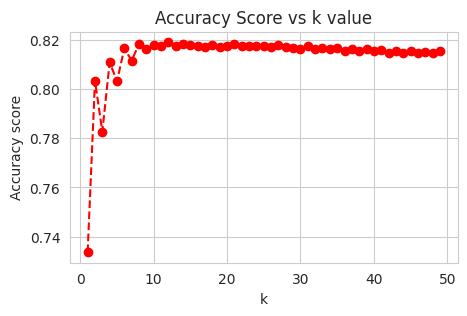

In [193]:
plt.figure(figsize = (5, 3))
plt.plot(K, Acc, color = 'red', linestyle = 'dashed', marker = 'o')
plt.title('Accuracy Score vs k value')
plt.xlabel('k')
plt.ylabel('Accuracy score')

The best accuracy score was 0.819 obtained for k = 12.

We can also change the weights parameter to find better results.


In [195]:
maxi, max, best_weight = 0, 0, 'uniform'
Acc = {'uniform':[], 'distance':[]}
K = range(1, 50)
for w in ['uniform', 'distance']:
  for k in K:
    knn = KNeighborsClassifier(p = 1, n_neighbors = k, weights = w)
    scores = cross_val_score(knn, X_train, y_train, cv = 5)
    Acc[w].append(np.mean(scores))
    if np.mean(scores) > maxi:
      maxi, max, best_weight = np.mean(scores), k, w
print(maxi, max, best_weight)

0.8189268443803337 12 uniform


Text(0, 0.5, 'Accuracy score')

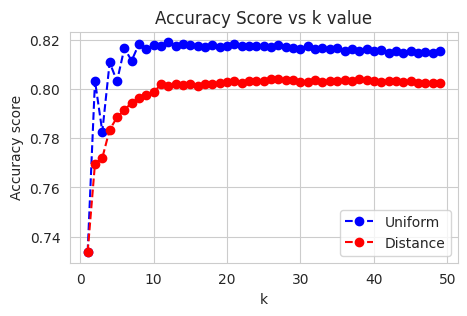

In [196]:
plt.figure(figsize = (5, 3))
plt.plot(K, Acc['uniform'], color = 'blue', linestyle = 'dashed', marker = 'o')
plt.plot(K, Acc['distance'], color = 'red', linestyle = 'dashed', marker = 'o')
plt.title('Accuracy Score vs k value')
plt.legend(["Uniform", "Distance"], loc="lower right")
plt.xlabel('k')
plt.ylabel('Accuracy score')

The best parameters for Manhattan distance are [n_neighbors, weights] = [12, 'Uniform'] with a score of 0.819.

Now let's look at the Euclidian distance.

In [ ]:
knn_eucl = KNeighborsClassifier(p = 2)

In [ ]:
knn_eucl.fit(X_train, y_train)

KNeighborsClassifier()

First let's choose the best k value for Euclidian distance with cross validation on train set.

We will try with two different weights parameters.


In [200]:
maxi, max, best_weight = 0, 0, 'uniform'
Acc = {'uniform':[], 'distance':[]}
K = range(1, 50)
for w in ['uniform', 'distance']:
  for k in K:
    knn = KNeighborsClassifier(p = 2, n_neighbors = k, weights = w)
    scores = cross_val_score(knn, X_train, y_train, cv = 5)
    Acc[w].append(np.mean(scores))
    if np.mean(scores) > maxi:
      maxi, max, best_weight = np.mean(scores), k, w
print(maxi, max, best_weight)

0.815311386163376 11 uniform


Text(0, 0.5, 'Accuracy score')

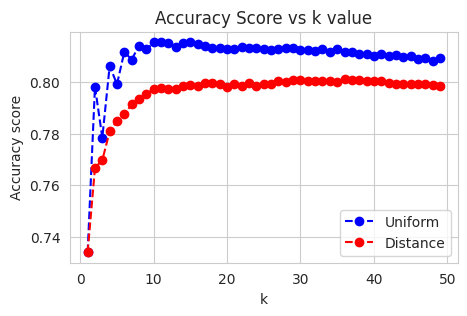

In [201]:
plt.figure(figsize = (5, 3))
plt.plot(K, Acc['uniform'], color = 'blue', linestyle = 'dashed', marker = 'o')
plt.plot(K, Acc['distance'], color = 'red', linestyle = 'dashed', marker = 'o')
plt.title('Accuracy Score vs k value')
plt.legend(["Uniform", "Distance"], loc="lower right")
plt.xlabel('k')
plt.ylabel('Accuracy score')

The best parameters for Euclidian distance are [n_neighbors, weights] = [11, uniform] with a score of 0.815.

The best overall parameters for the model are : [distance, n_neighbors, weights] = ['Manhattan', 12, 'Uniform'] . We will use this model on the test set.

In [451]:
knn = KNeighborsClassifier(p = 1, n_neighbors = 12, weights = 'uniform')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

In [452]:
from sklearn.metrics import confusion_matrix

In [453]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[2497,   21],
       [ 504,   91]])

Next is a heatmap representing the confusion matrix obtained with the best model.

Text(95.72222222222221, 0.5, 'Truth')

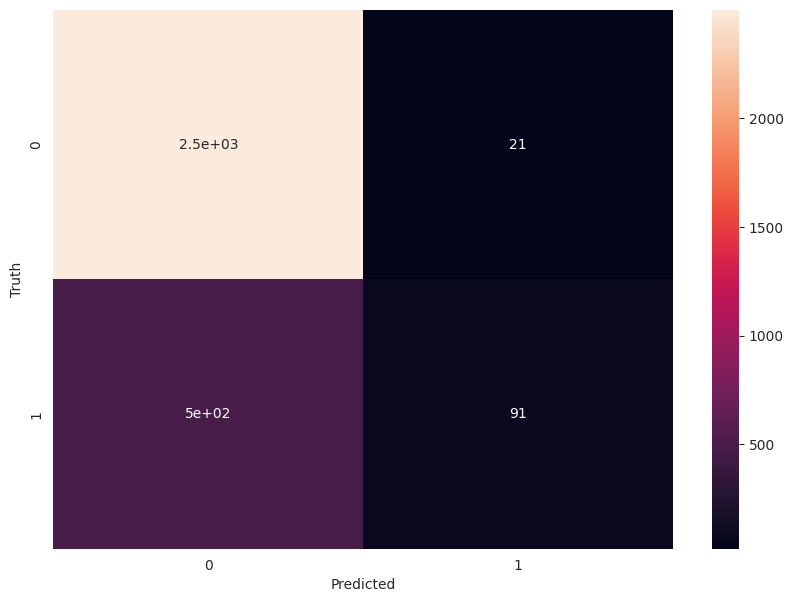

In [454]:
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Next is the score of the best model on the test set.

In [455]:
tn, fp, fn, tp = cm.ravel()

In [456]:
Acc = (tp + tn)/(tp + tn + fn + fp)
Pre = tp/(tp + fp)
Rec = tp/(tp + fn)

In [342]:
Acc

0.8204304529392868

In [343]:
Pre

0.68

In [344]:
Rec

0.11428571428571428

The accuracy = 0.82

The presicion = 0.68

The recall = 0.114

Saving the best model

In [457]:
filename = 'Knn.sav'
with open(filename, 'wb') as file:
    pickle.dump(knn, file)
files.download('Knn.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Logistic Regression + K-Means - Supermarket Dataset




In [514]:
sales = pd.read_csv('supermarket_sales.csv')

## EDA

In [515]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

There are no missing values in this dataset.

In [516]:
sales.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


We will first see if each Invoice IDs are different.

In [517]:
sales['Invoice ID'].nunique() == sales.shape[0]

True

Indeed, each Invoice ID is unique and seems random. We can't extract any information about the ratings from it, wo we can drop the column.

Then, as asked, we create categories for different values of ratings : Low, Medium and High.

In [518]:
sales['RatingGroup'] = pd.cut(sales['Rating'], bins=[0, 5.5, 7.5, float('Inf')], labels=['low', 'medium', 'high'])

<Axes: xlabel='Rating', ylabel='count'>

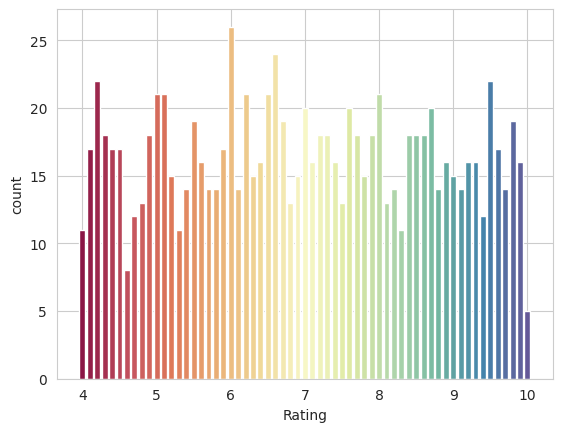

In [519]:
sns.set_style('whitegrid')
sns.countplot(x='Rating', data=sales, palette='Spectral', native_scale = True)

<Axes: xlabel='RatingGroup', ylabel='count'>

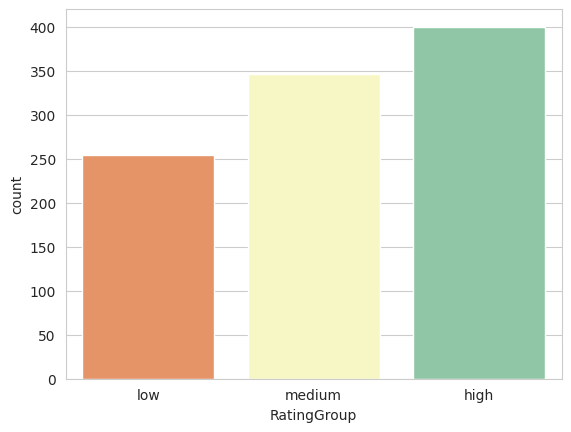

In [520]:
sns.set_style('whitegrid')
sns.countplot(x='RatingGroup', data=sales, palette='Spectral', native_scale = True)

We can see with this diagram that data is not equally distributed between the different categories.

For the study, we are only going to use "Rating groups" as logistic regression can only predict categorical variables.

Now let's study the dataset in more detail. THe next diagram represents the repartition of the branches in different cities.

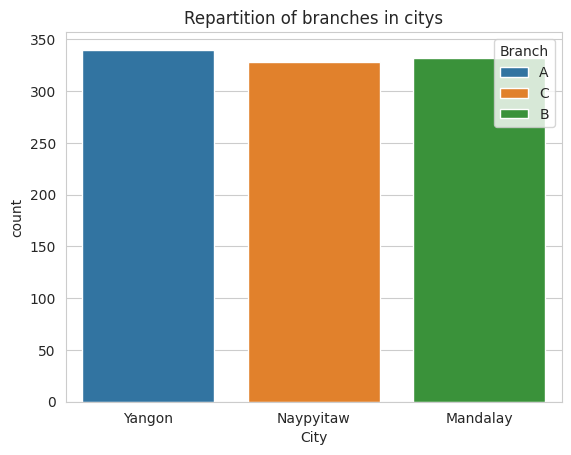

In [521]:
sns.set_style('whitegrid')
ax = sns.countplot(x='City', hue = 'Branch', data=sales)

plt.title("Repartition of branches in citys")

plt.show()

As, we can see with this plot, each city has its own branch. That means that both columns contain the same information : so we can drop the "City" column.

One useful information about marketing could be the category of person targeted by one product. Here, we are going to see the total amount spent on each Product Line by both sexes.

In [522]:
Gender_product = sales.groupby(['Product line', 'Gender']).mean("Total")["Total"]

In [523]:
pd.DataFrame(Gender_product)

Total
Product line           Gender            
Electronic accessories Female  322.643125
                       Male    316.691965
Fashion accessories    Female  317.056250
                       Male    291.079207
Food and beverages     Female  368.565750
                       Male    273.499125
Health and beauty      Female  290.015414
                       Male    348.099460
Home and lifestyle     Female  380.213639
                       Male    294.136241
Sports and travel      Female  324.712739
                       Male    340.360327

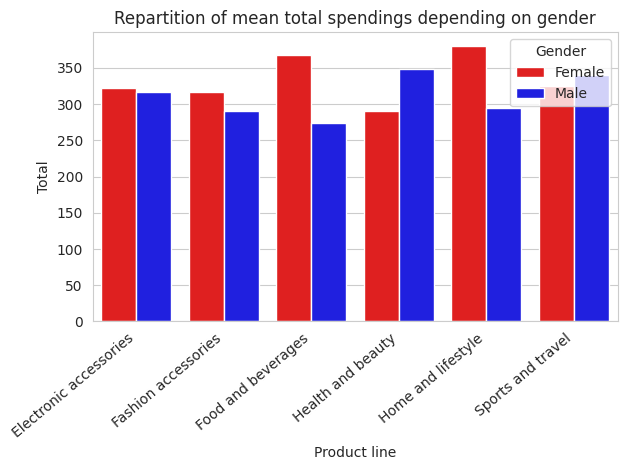

In [524]:
sns.set_style('whitegrid')
ax = sns.barplot(x='Product line', y='Total', hue = 'Gender', data=pd.DataFrame(Gender_product), palette = ['red','blue'])

plt.title("Repartition of mean total spendings depending on gender")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We can see that, on average, women tend to spend more money than men on "Food and beverages" as well as "Home and lifestyle", when men spend more on "Health and beauty".

In [525]:
len(sales["gross margin percentage"].unique()) == 1

True

In [526]:
margin_perc = sales["gross margin percentage"].unique()[0]

All gross margin percentage are the same so it doesn't give us any information to differentiate the data. We can delete this column.

We can regroup every column linked to economy to see if some are correlated.

In [527]:
economy = sales[['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross margin percentage', 'gross income']]
economy.head()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085


In [528]:
all(abs(economy['Total'] - (economy['Unit price']*economy['Quantity'] + economy['Tax 5%'])) < 0.000000001)

True

In [529]:
all(economy['cogs'] == round(economy['Unit price']*economy['Quantity'], 2))

True

This two previous lines gives us the next equality :
Total = UnitPrice*Quantity + Tax5% = cogs + Tax5% .

In [530]:
all(economy['gross income'] == economy['Tax 5%'])

True

Moreover, we also have : Gross income = Tax 5%

We also need to convert dates and time into type that are usable by the model : categorical variables.

In [531]:
sales[["Date", "Time"]].head()

,Date,Time
0,1/5/2019,13:08
1,3/8/2019,10:29
2,3/3/2019,13:23
3,1/27/2019,20:33
4,2/8/2019,10:37


The year being always the same (2019), we are only going to only keep the month and the hour in which the purchase was done.

In [532]:
from datetime import datetime

In [533]:
sales['Month'] = sales['Date']
for i in range(len(sales[['Date']])):
  sales['Month'][i] = sales["Date"][i][0]

In [534]:
sales['Hour'] = sales['Time']
for i in range(len(sales[['Time']])):
  sales['Hour'][i] = sales['Time'][i][:2]

In [535]:
sales[['Date', 'Time', 'Month', 'Hour']]

,Date,Time,Month,Hour
0,1/5/2019,13:08,1,13
1,3/8/2019,10:29,3,10
2,3/3/2019,13:23,3,13
3,1/27/2019,20:33,1,20
4,2/8/2019,10:37,2,10
...,...,...,...,...
995,1/29/2019,13:46,1,13
996,3/2/2019,17:16,3,17
997,2/9/2019,13:22,2,13
998,2/22/2019,15:33,2,15


In [536]:
sales.drop(['Date', 'Time'], axis = 'columns', inplace = True)

Now we are going to see at what time and during which month are their more sales.

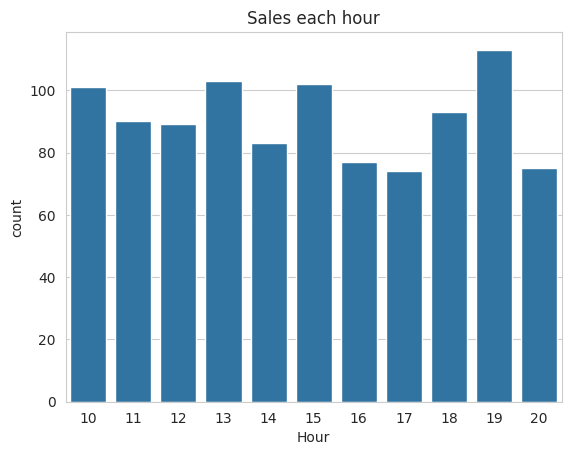

In [537]:
order_hour = sales.sort_values(by = ['Hour'])

sns.set_style('whitegrid')
ax = sns.countplot(x='Hour', data=order_hour)

plt.title("Sales each hour")

plt.show()

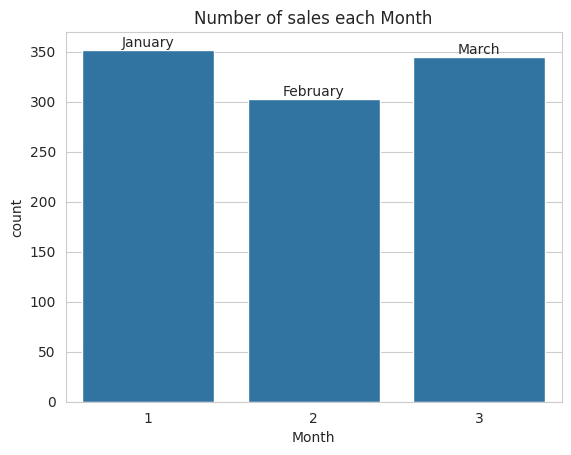

In [538]:
order_month = sales.sort_values(by = ['Month'])

sns.set_style('whitegrid')
ax = sns.countplot(x='Month', data=order_month)

plt.title("Number of sales each Month")
plt.xlabel('Month')
ax.bar_label(container=ax.containers[0], labels=['January', 'February', 'March'])

plt.show()

Now we are going to see the total won each month for the brand.

In [539]:
TotMonth = sales.groupby('Month').sum('Total')['Total']

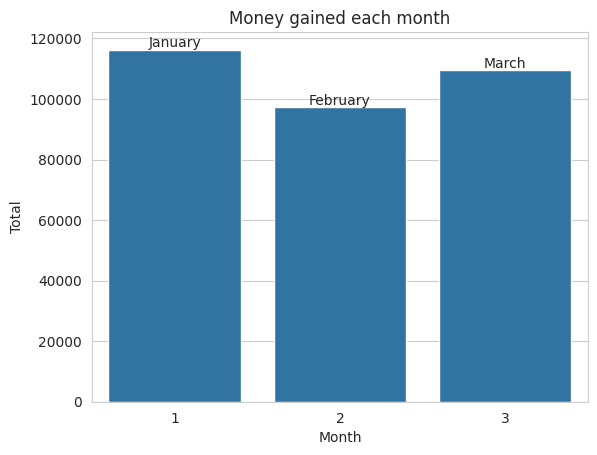

In [540]:
sns.set_style('whitegrid')
ax = sns.barplot(data=TotMonth)

plt.title("Money gained each month")
plt.xlabel('Month')
ax.bar_label(container=ax.containers[0], labels=['January', 'February', 'March'])

plt.show()

We can see that more sales are made during January and March. Consequently, more money is gained by the supermarket.

##Cleaning and preprocessing

In [541]:
sales.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating,RatingGroup,Month,Hour
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1,high,1,13
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6,high,3,10
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4,medium,3,13
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4,high,1,20
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3,low,2,10


First, we need to keep only independent variables for logistic regression. But, as we have seen it sooner, not every variables are independent, so we need to suppress some of them.

We are going to delete :
*   *cogs* = Unit * Quantity
*   *Gross Income* = Tax5%
*   *Total* = Unit*Quantity + Tax5%
*   *Gross margin percentage* which is a constant so has no incidence on the result
*   *Invoice ID* which is unique to every purchase so has no incidence on the rating
*   And finally *Ratings*, as we now are going to use Rating groups as asked in the assignment.







In [542]:
sales.drop(['cogs', 'gross income', 'Total', 'gross margin percentage', 'Invoice ID', 'Rating'], axis = 'columns', inplace = True)

In [543]:
inputs = sales.drop(['RatingGroup'], axis = 'columns')

In [544]:
target = sales['RatingGroup']

Then we have to create dummy variables for non-numerical variables:

*   Branch
*   City
*   Customer type
*   Gender
*   Product line
*   Payment
*   Month and Hour (As, it doesn't make sense to keep them a number)

In [545]:
dummies_branch = pd.get_dummies(inputs['Branch'], drop_first = True)

In [546]:
dummies_city = pd.get_dummies(inputs['City'], drop_first = True)

In [547]:
dummies_customerType = pd.get_dummies(inputs['Customer type'], drop_first = True)

In [548]:
dummies_gender = pd.get_dummies(inputs['Gender'], drop_first = True)

In [549]:
dummies_prodLine = pd.get_dummies(inputs['Product line'], drop_first = True)

In [550]:
dummies_payment = pd.get_dummies(inputs['Payment'], drop_first = True)

In [551]:
dummies_month = pd.get_dummies(inputs['Month'], drop_first = True)

In [552]:
dummies_hour = pd.get_dummies(inputs['Hour'], drop_first = True)

In [553]:
inputs.drop(['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment', 'Month', 'Hour'], axis='columns', inplace=True)

In [554]:
inputs = pd.concat([inputs, dummies_branch, dummies_city, dummies_customerType, dummies_gender, dummies_prodLine, dummies_payment, dummies_month, dummies_hour], axis = 'columns')

In [555]:
inputs.head()

,Unit price,Quantity,Tax 5%,B,C,Naypyitaw,Yangon,Normal,Male,Fashion accessories,...,11,12,13,14,15,16,17,18,19,20
0,74.69,7,26.1415,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,15.28,5,3.8200,False,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,46.33,7,16.2155,False,False,False,True,True,True,False,...,False,False,True,False,False,False,False,False,False,False
3,58.22,8,23.2880,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,86.31,7,30.2085,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [556]:
target.head()

0      high
1      high
2    medium
3      high
4       low
Name: RatingGroup, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

## Export cleaned datasets

In [503]:
inputs["RatingGroup"] = target

In [504]:
inputs.head()

,Unit price,Quantity,Tax 5%,B,C,Naypyitaw,Yangon,Normal,Male,Fashion accessories,...,12,13,14,15,16,17,18,19,20,RatingGroup
0,74.69,7,26.1415,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,high
1,15.28,5,3.8200,False,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,high
2,46.33,7,16.2155,False,False,False,True,True,True,False,...,False,True,False,False,False,False,False,False,False,medium
3,58.22,8,23.2880,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,high
4,86.31,7,30.2085,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,low


In [505]:
inputs.to_csv('CleanedSupermarket.csv')
files.download('CleanedSupermarket.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Train-Test Split

In [557]:
from sklearn.model_selection import train_test_split

In [558]:
# 80 - 20 Split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.2, random_state = 10)

## Logistic regression

We will start by mesuring the score of the model using default parameters with cross validation.

In [559]:
from sklearn.linear_model import LogisticRegression

In [560]:
logmodel = LogisticRegression()
scores = cross_val_score(logmodel, X_train, y_train, cv = 5)
scores

array([0.35625, 0.3375 , 0.3875 , 0.44375, 0.36875])

In [561]:
np.mean(scores)

0.37875

With this model, we can change a few parameters, such as :
*   The penalty (None or l2)
*   The regularization (C)




In [351]:
import warnings
warnings.filterwarnings('ignore')

In [562]:
best_penalty, best_C = 'None', 0
maxi = 0
scores = pd.DataFrame(columns=['Penalty', 'C', 'Score'])
for penalty_ in ['none', 'l2']:
  print(penalty_)
  for C_ in [0.01, 0.1, 1, 10, 100]:
    print(C_)
    score = 0
    for i in range(10):
      logmodel = LogisticRegression(penalty = penalty_, C = C_, max_iter = 1000000)
      score += np.mean(cross_val_score(logmodel, X_train, y_train, cv = 5))
    new_score = pd.DataFrame([[penalty_,C_,score/10]], columns=['Penalty','C','Score'])
    scores = pd.concat([scores, new_score])
    if score/10 > maxi:
      maxi = score/10
      best_penalty = penalty_
      best_C = C_
print(maxi, best_penalty, best_C)

none
0.01
0.1


KeyboardInterrupt: 

Next are a representation of the results of each model, depending on the parameter.

In [ ]:
sns.set_style('whitegrid')
ax = sns.barplot(x='Penalty', y='Score', hue = 'C', data=scores)

plt.xlabel("Penalty")
plt.ylabel("Score")
plt.title("Score obtained with different methods")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The best score was 0.4 obtained with the model with the following parameters : [Penalty : 'l2', C : 0.1]

In reality, the value of C is only useful when penalties are taken into account.

Let's build the best model and see its result on the test set.


In [563]:
logmodel = LogisticRegression(penalty = 'l2', C = 0.1)
logmodel.fit(X_train, y_train)
y_predict = logmodel.predict(X_test)

In [564]:
from sklearn.metrics import confusion_matrix

In [565]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[55,  3, 26],
       [33,  2, 19],
       [39,  5, 18]])

Next is a heatmap representing the confusion matrix obtained with the best model.

Text(95.72222222222221, 0.5, 'Truth')

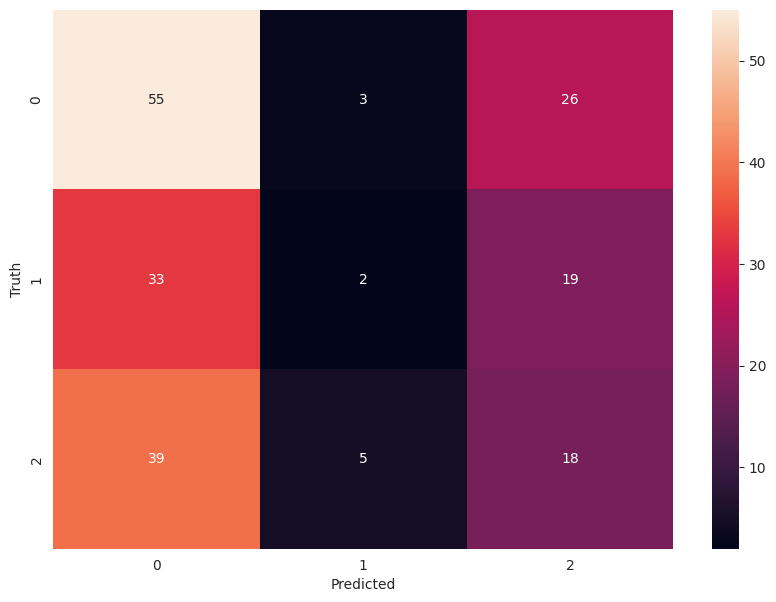

In [566]:
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Next is the score of the best model on the test set.

In [567]:
cm.ravel()

array([55,  3, 26, 33,  2, 19, 39,  5, 18])

In [568]:
t0, f0_1, f0_2, f1_0, t1, f1_2, f2_0, f2_1, t2 = cm.ravel()

In [569]:
Acc = (t0 + t1 + t2)/sum(cm.ravel())

In [570]:
Acc

0.375

The accuracy = 0.375

Saving the best model

In [571]:
filename = 'LogReg.sav'
with open(filename, 'wb') as file:
    pickle.dump(logmodel, file)
files.download('LogReg.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## K-Means algorithm

In [572]:
from sklearn.cluster import KMeans

The K-means algorithm doesn't need training and testing sets.

In [573]:
X = inputs
y = target

In [574]:
y = pd.DataFrame(data = y.values, columns=['Rating'])

In [575]:
kmeans = KMeans(n_clusters=3, random_state=10, init="k-means++", algorithm="lloyd")
kmeans.fit(X)
res = pd.DataFrame(data = kmeans.labels_, columns=['Rating'])

In [576]:
res.head()

,Rating
0,1
1,2
2,0
3,0
4,1


In [59]:
y.head()

,Rating
0,high
1,high
2,medium
3,high
4,low


The problem with the kmeans algorithm is that it is a clustering algorithm, so we then need to recognize the groups it formed. To do that, we are going to interpret the results multiple ways, and keep the one that gives us the best accuracy.

In [577]:
def score_(res:pd.DataFrame, y:pd.DataFrame):
  """Finds the interpretation and the score of the result of the kmeans algorithm"""
  max = 0
  best = {"low":0, "medium":1, "high":2}
  for i in range(0, 3):
    for j in range(0, 3):
      for k in range(0, 3):
        if i!=j and j!=k and i!=k:
          temp = res.replace(to_replace=[i, j, k], value=["low", "medium", "high"])
          acc = sum(temp['Rating'] == y['Rating'])/len(res)
          if acc > max:
            best['low'] = i
            best['medium'] = j
            best['high'] = k
            max = acc
  return(best, max)

1. {init="k-means++", algorithm='lloyd'}

In [61]:
score_(res, y)

({'low': 1, 'medium': 0, 'high': 2}, 0.358)

So, the accuracy found with the initial parameters is 0.358. We will try to twick the parameters to enhance this result.

Let's find better parameters for this model.



2.   {init="k-means++", algorithm='elkan'}

In [62]:
kmeans = KMeans(n_clusters=3, random_state=10, init = "k-means++", algorithm = "elkan")
kmeans.fit(X)
res = pd.DataFrame(data = kmeans.labels_, columns=['Rating'])
score_(res, y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({'low': 1, 'medium': 0, 'high': 2}, 0.358)

3. {init=‘random’, algorithm='lloyd'}

In [63]:
kmeans = KMeans(n_clusters=3, random_state=10, init = "random")
kmeans.fit(X)
res = pd.DataFrame(data = kmeans.labels_, columns=['Rating'])
score_(res, y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({'low': 2, 'medium': 0, 'high': 1}, 0.358)

4. {init=‘random’, algorithm='elkan'}

In [64]:
kmeans = KMeans(n_clusters=3, random_state=10, init = "random", algorithm = "elkan")
kmeans.fit(X)
res = pd.DataFrame(data = kmeans.labels_, columns=['Rating'])
score_(res, y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({'low': 2, 'medium': 0, 'high': 1}, 0.358)

The result doesn't change with the algorithm, so we will take {init=‘random’, algorithm='lloyd'}.

Show result on test set(confusion matrix).


In [578]:
kmeans = KMeans(n_clusters=3, random_state=10, init = "random", algorithm = "lloyd")
kmeans.fit(X)
res = pd.DataFrame(data = kmeans.labels_, columns=['Rating'])
score = score_(res, y)

In [579]:
target.head()

0      high
1      high
2    medium
3      high
4       low
Name: RatingGroup, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [580]:
score

({'low': 2, 'medium': 0, 'high': 1}, 0.358)

In [581]:
target.replace(to_replace=list(score[0].keys()), value=list(score[0].values()), inplace = True)

Confusion matrix with best parameters

In [582]:
cm = confusion_matrix(target, res)
cm

array([[124, 121, 101],
       [127, 138, 135],
       [ 80,  78,  96]])

Text(95.72222222222221, 0.5, 'Truth')

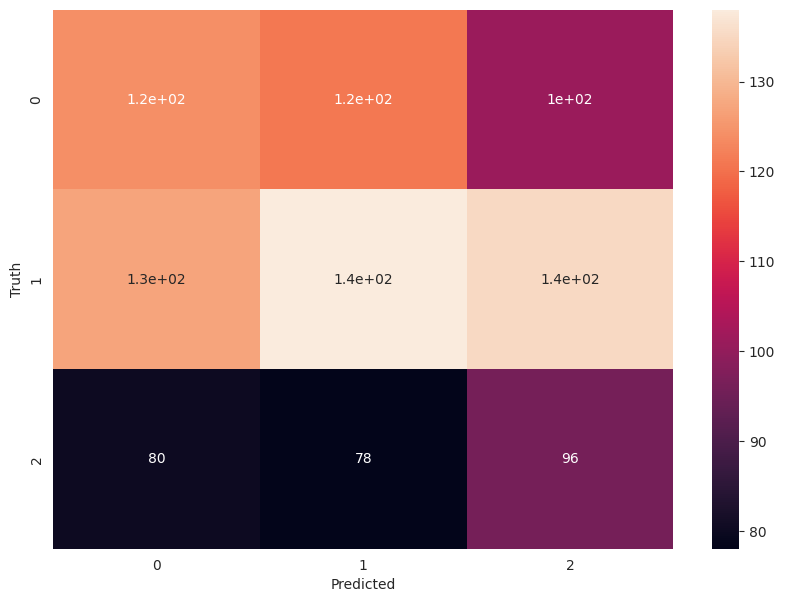

In [583]:
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Next is the score of the best model on the test set.

In [584]:
cm.ravel()

array([124, 121, 101, 127, 138, 135,  80,  78,  96])

In [585]:
t0, f0_1, f0_2, f1_0, t1, f1_2, f2_0, f2_1, t2 = cm.ravel()

In [586]:
Acc = (t0 + t1 + t2)/sum(cm.ravel())

In [587]:
Acc

0.358

The accuracy = 0.358

Saving the best model

In [588]:
filename = 'KMeans.sav'
with open(filename, 'wb') as file:
    pickle.dump(kmeans, file)
files.download('KMeans.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>